# System Threat Forecaster - Complete ML Pipeline

# **22f3002743 - Anshul Ramdas Baliga**

In [ ]:
#Feedback from Level1 viva:
    #optuna in separate notebook

# **1. Data Loading and Exploration**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import optuna
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Display dataset information
train = pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
print("Magnitude of the dataset: ")
print(train.size)
print("\nBrief description of the dataset: ")
train.info()

Magnitude of the dataset: 
7600000

Brief description of the dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEn

In [3]:
# Load test data
test = pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')
    
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print("\nFeature types:\n", train.dtypes.value_counts())

# Sample data for faster execution
train_df = train
test.info

Training data shape: (100000, 76)
Test data shape: (10000, 75)

Feature types:
 float64    31
object     28
int64      17
Name: count, dtype: int64


<bound method DataFrame.info of                              MachineID   ProductName EngineVersion  \
0     c2c61173092ad20db5585ca8c10de6e0  win8defender   1.1.15100.1   
1     2e6bb5362ba1ce897feeb1de5edea686  win8defender   1.1.15100.1   
2     692649baed1c50bb8d051ae7f06e3625  win8defender   1.1.15200.1   
3     2ff95e7d97e9f80ec81c97622dd93ed6  win8defender   1.1.15300.6   
4     256766b4c5011e146f05b323863e08a4  win8defender   1.1.14800.3   
...                                ...           ...           ...   
9995  42d3ddb25eeb149517e2b6871b061df4  win8defender   1.1.15200.1   
9996  3d474c494d797cafc2ab1665711f0f91  win8defender   1.1.15100.1   
9997  9aee2fc73af8240a688ceb83d41c0418  win8defender   1.1.15200.1   
9998  a2f8c1f88b78271c38767fe43850b359  win8defender   1.1.15200.1   
9999  c1c85a860e30097b03c815aa908cd17d  win8defender   1.1.15000.2   

            AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0      4.18.1807.18075     1.273.1276.0        

In [4]:
# Categorical data
categorical_df = train_df.select_dtypes(include=['object'])
categorical_df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,PlatformType,Processor,OSVersion,OsPlatformSubRelease,OSBuildLab,...,OSBranch,OSEdition,OSSkuFriendlyName,OSInstallType,AutoUpdateOptionsName,OSGenuineState,LicenseActivationChannel,FlightRing,DateAS,DateOS
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,windows10,x86,10.0.0.0,rs1,14393.2214.x86fre.rs1_release_1.180402-1758,...,rs1_release,Core,CORE,Update,UNKNOWN,IS_GENUINE,Retail,Retail,2018-09-10 10:11:00,2018-04-17
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,...,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,2018-08-16 00:01:00,2018-08-14
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,...,rs4_release,Core,CORE,Reset,FullAuto,IS_GENUINE,OEM:NONSLP,Retail,2018-09-20 23:20:00,2018-09-11
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,windows10,x64,10.0.0.0,rs2,15063.0.amd64fre.rs2_release.170317-1834,...,rs2_release,Core,CORE,Upgrade,UNKNOWN,IS_GENUINE,OEM:DM,Retail,2018-09-14 00:32:00,2018-01-03
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,windows10,x86,10.0.0.0,rs4,17134.1.x86fre.rs4_release.180410-1804,...,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail,2018-09-15 19:34:00,2018-09-11


In [5]:
# Numerical data
numerical_df = train_df.select_dtypes(include=['int64','float64'])
numerical_df.head(20)

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
0,0,7.0,0,53447.0,1.0,1.0,1,51,120232.0,98.0,...,513.0,21964.0,0,0.0,1,0,1.0,0.0,6.0,0
1,0,7.0,0,53447.0,1.0,1.0,1,141,112854.0,167.0,...,628.0,44548.0,1,0.0,0,0,0.0,0.0,10.0,1
2,0,7.0,0,53447.0,1.0,1.0,1,51,41759.0,98.0,...,142.0,9414.0,0,0.0,0,0,0.0,1.0,6.0,1
3,0,7.0,0,46413.0,2.0,1.0,1,68,19507.0,276.0,...,554.0,33060.0,1,0.0,0,0,0.0,0.0,12.0,1
4,0,7.0,0,40466.0,2.0,1.0,1,43,117801.0,53.0,...,628.0,13224.0,0,0.0,0,0,0.0,1.0,7.0,0
5,0,7.0,0,53447.0,1.0,1.0,1,35,36157.0,45.0,...,355.0,20050.0,0,0.0,0,0,0.0,1.0,4.0,0
6,0,7.0,0,53447.0,1.0,1.0,1,91,145233.0,277.0,...,142.0,3561.0,0,0.0,0,0,0.0,0.0,11.0,0
7,0,7.0,0,53447.0,1.0,1.0,1,18,37376.0,277.0,...,554.0,33115.0,0,0.0,0,0,0.0,0.0,1.0,1
8,0,7.0,0,53447.0,1.0,1.0,1,18,37378.0,277.0,...,127.0,63086.0,0,0.0,0,0,0.0,0.0,1.0,0
9,0,7.0,0,53447.0,1.0,1.0,1,158,117594.0,202.0,...,554.0,33111.0,1,0.0,0,0,0.0,1.0,1.0,1


# [](http://)**2. Exploratory Data Analysis (EDA-1)**


--- Exploratory Data Analysis ---
Training data shape: (100000, 76)
Target distribution:
target
1    0.50525
0    0.49475
Name: proportion, dtype: float64
Features with missing values:
RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeCapacityMB                110
TotalPhysicalRAMMB                    151
ChassisType     

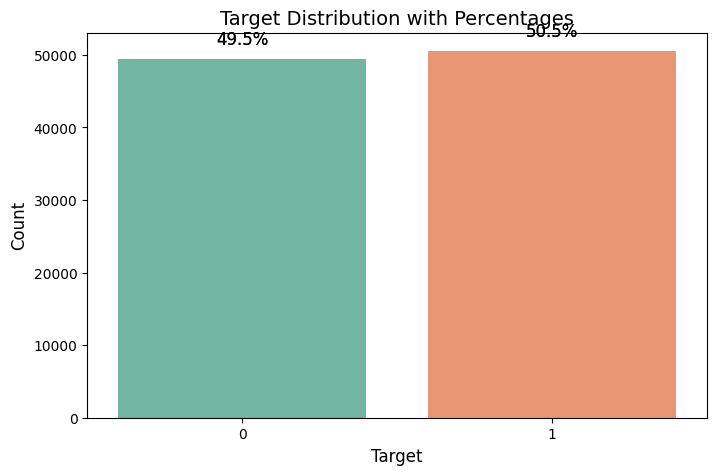

Number of numeric features: 48
Number of categorical features: 28


<Figure size 1500x1000 with 0 Axes>

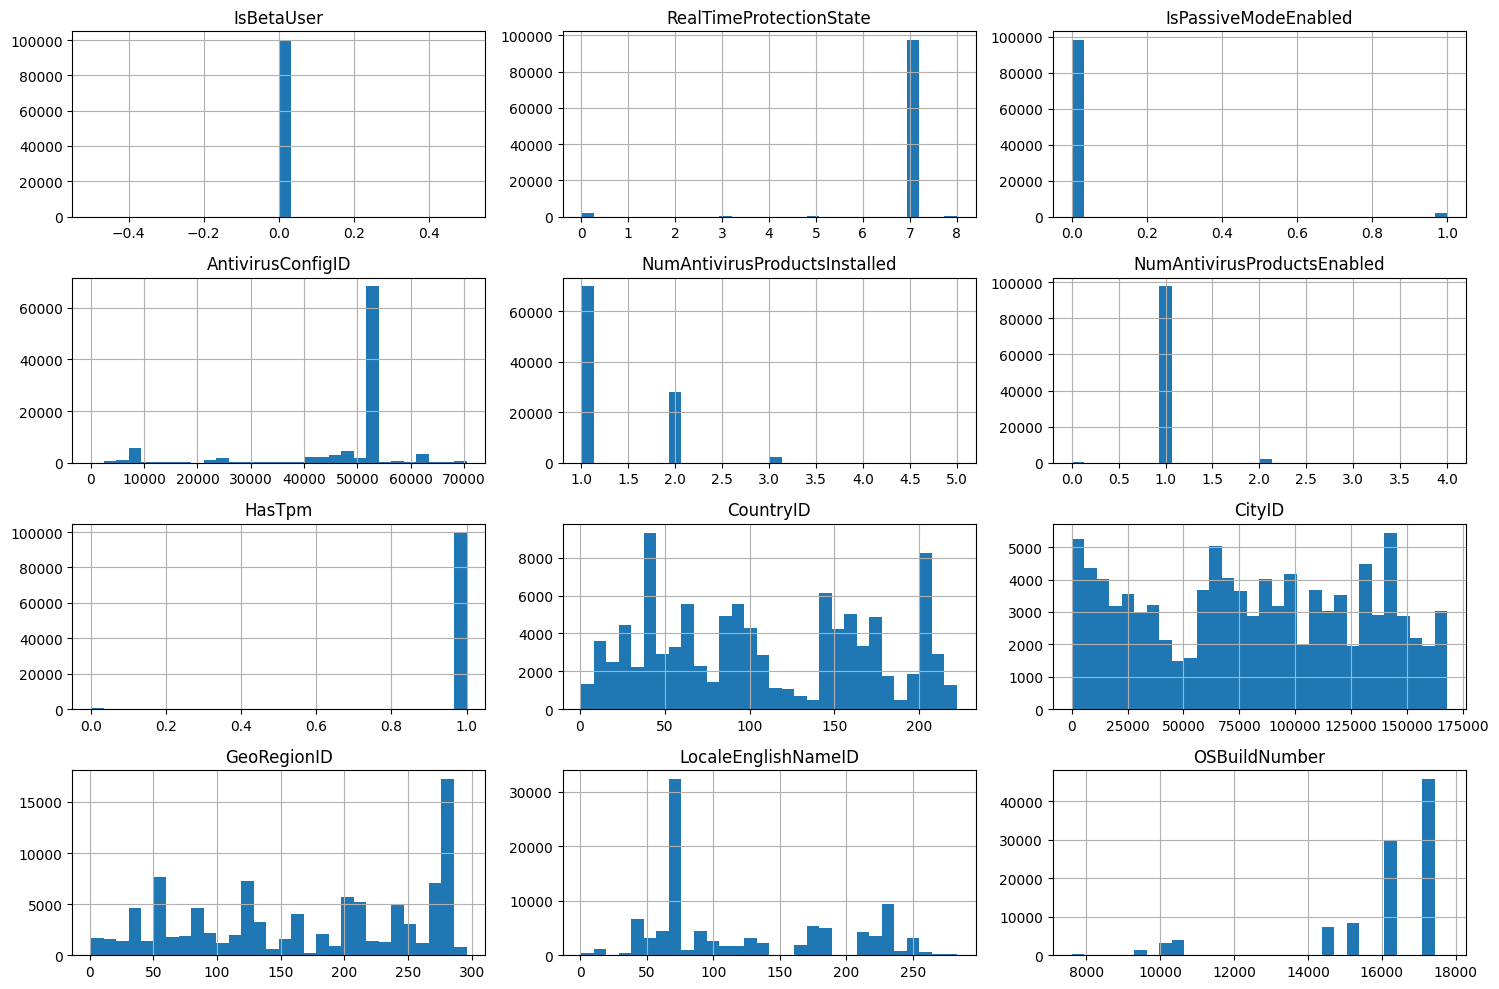

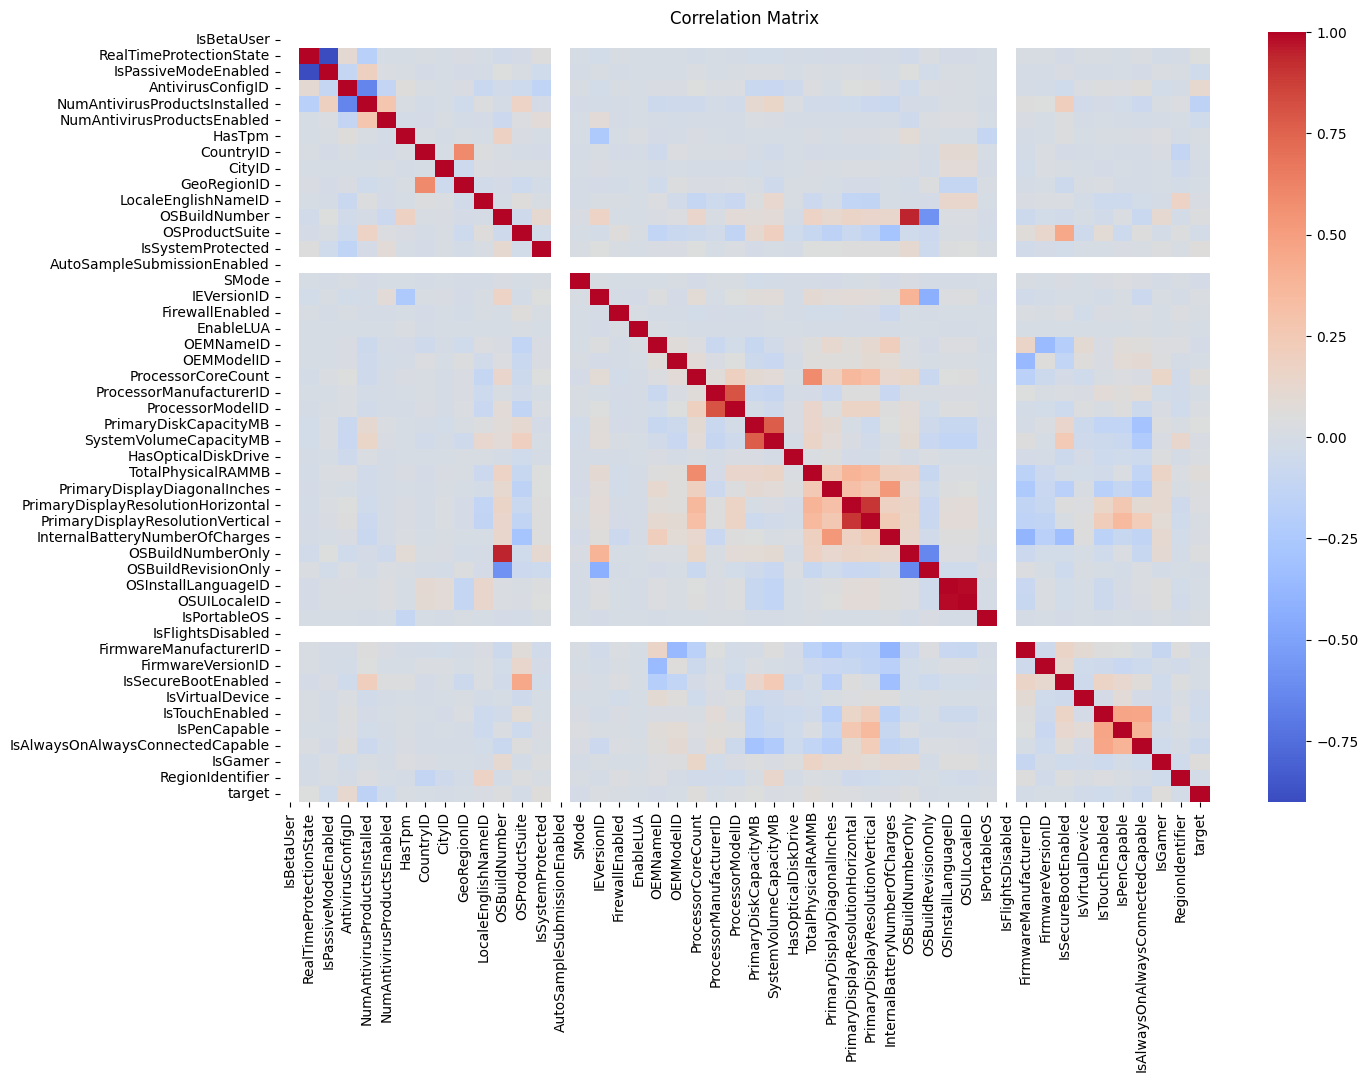


Top 10 positively correlated features with target:
AntivirusConfigID               0.118304
TotalPhysicalRAMMB              0.065747
IsSystemProtected               0.062401
IsGamer                         0.061191
ProcessorCoreCount              0.056769
PrimaryDiskCapacityMB           0.049117
RealTimeProtectionState         0.049012
OSBuildNumberOnly               0.038544
PrimaryDisplayDiagonalInches    0.035064
OSBuildNumber                   0.034712
Name: target, dtype: float64

Top 10 negatively correlated features with target:
FirmwareManufacturerID             -0.020420
IsVirtualDevice                    -0.039789
NumAntivirusProductsEnabled        -0.041547
IsPassiveModeEnabled               -0.041997
IsTouchEnabled                     -0.046142
IsAlwaysOnAlwaysConnectedCapable   -0.064776
NumAntivirusProductsInstalled      -0.151375
IsBetaUser                               NaN
AutoSampleSubmissionEnabled              NaN
IsFlightsDisabled                        NaN
Name: t

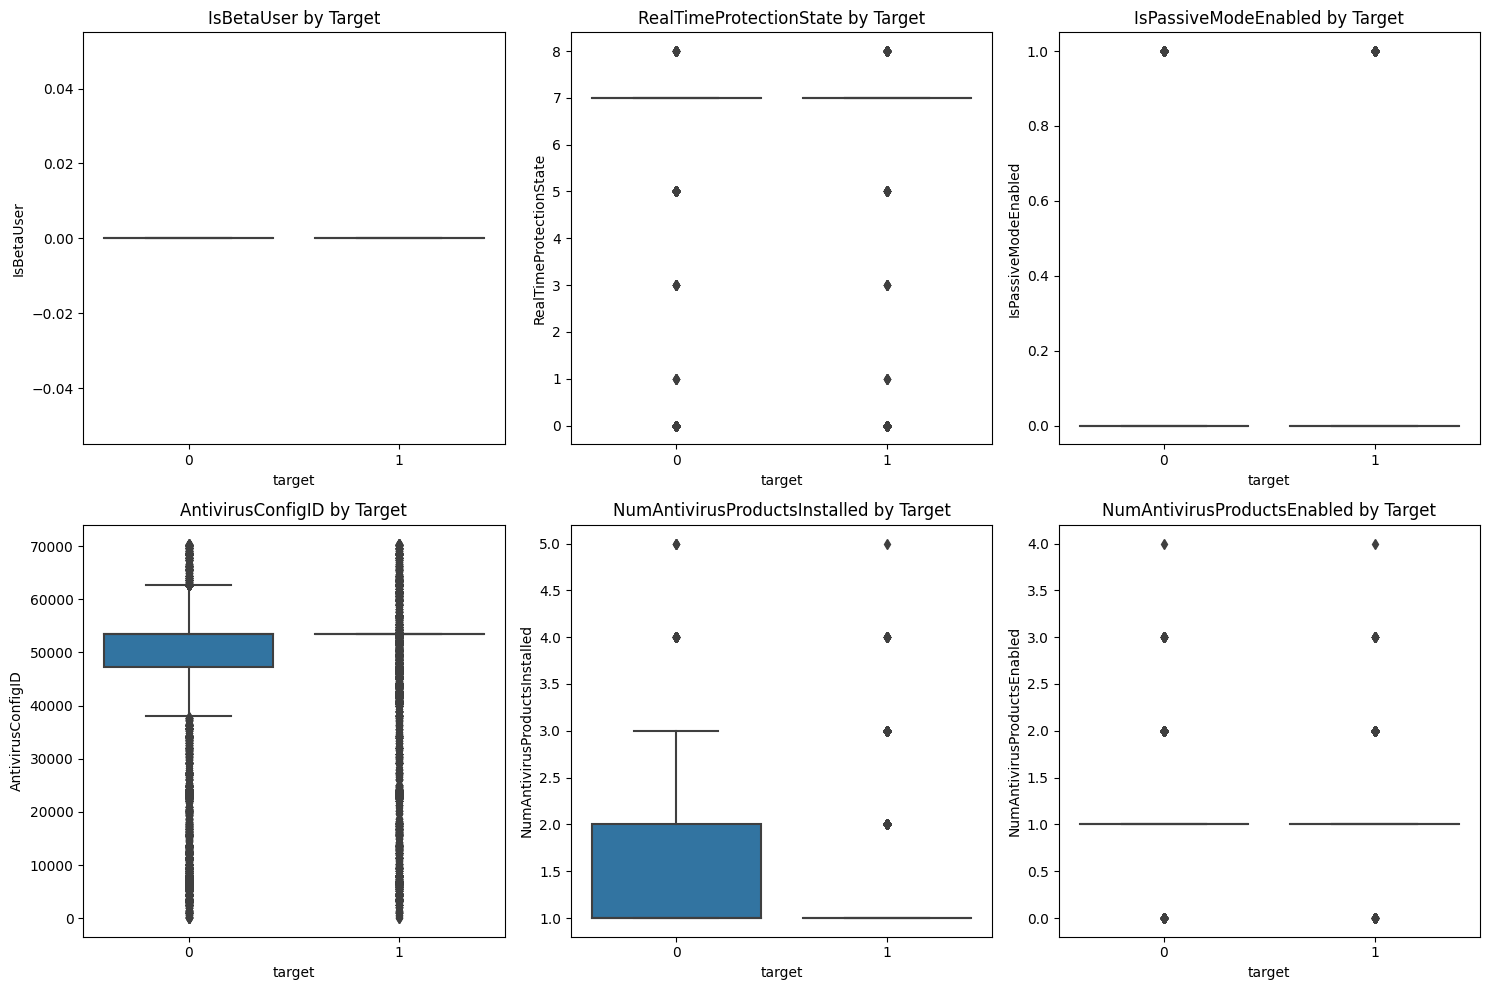

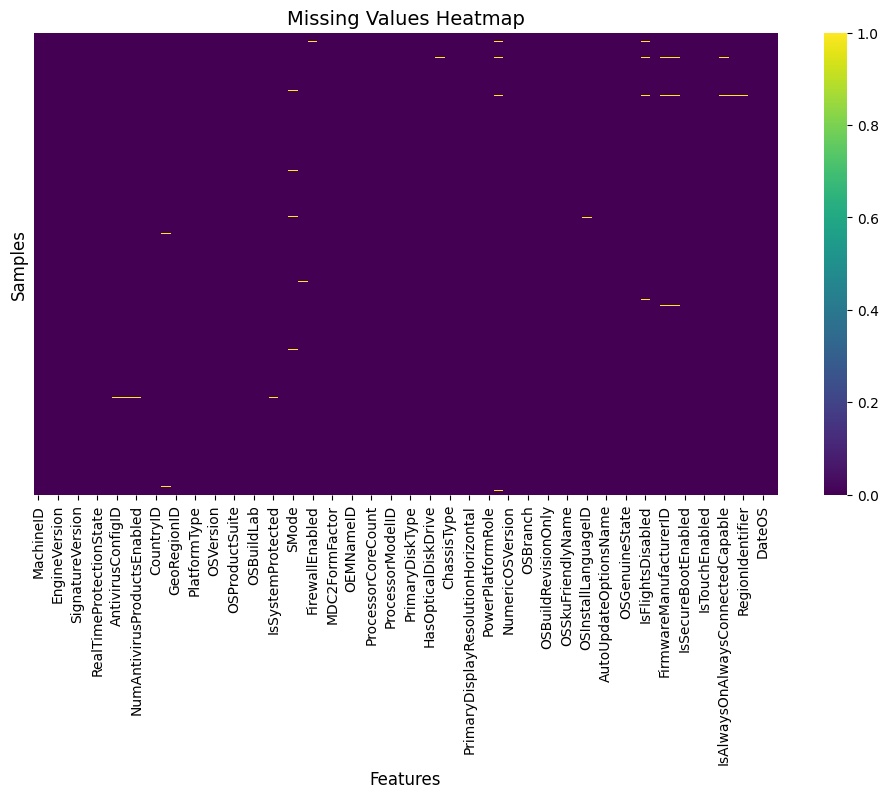

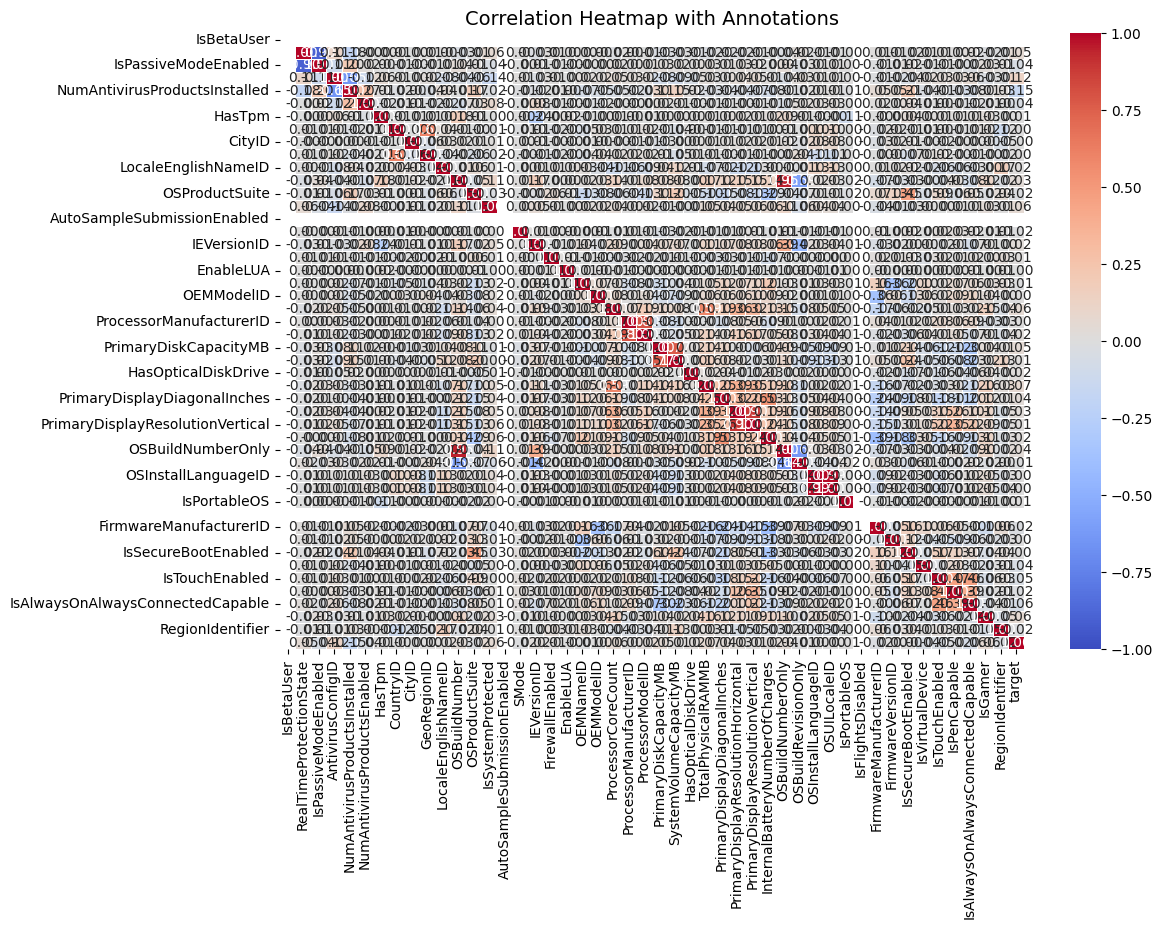

Available security-related columns: ['RealTimeProtectionState', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'FirewallEnabled']


In [6]:
    # Stage 2: EDA
    print("\n--- Exploratory Data Analysis ---")
    
    # Basic info
    print(f"Training data shape: {train_df.shape}")
    if 'target' in train_df.columns:
        print(f"Target distribution:\n{train_df['target'].value_counts(normalize=True)}")
    
    # Check missing values
    missing_values = train_df.isnull().sum()
    print(f"Features with missing values:\n{missing_values[missing_values > 0]}")
    
    # Plot target distribution
    if 'target' in train_df.columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x='target', data=train_df)
        ax = sns.countplot(x='target', data=train_df, palette='Set2')
        plt.title('Target Distribution with Percentages', fontsize=14)
    
        # Add percentages on top of bars
        total = len(train_df)
        for p in ax.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height() + 0.02 * total
            ax.annotate(percentage, (x, y), ha='center', fontsize=12)
    
        plt.xlabel('Target', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.show()
    
    # Feature types
    numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = train_df.select_dtypes(include=['object']).columns
    
    print(f"Number of numeric features: {len(numeric_features)}")
    print(f"Number of categorical features: {len(categorical_features)}")
    
    # Distribution of numerical features
    if len(numeric_features) > 0:
        plt.figure(figsize=(15, 10))
        train_df[numeric_features[:12]].hist(figsize=(15, 10), bins=30)
        plt.tight_layout()
        plt.show()
    
    # Correlation analysis (only for numeric features)
    if len(numeric_features) > 0:
        correlation = train_df[numeric_features].corr()
        plt.figure(figsize=(15, 10))
        sns.heatmap(correlation, annot=False, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()
    
    # Feature correlations with target (only for numeric features)
    if 'target' in train_df.columns and len(numeric_features) > 0:
        correlations_with_target = train_df[numeric_features].corr()['target'].sort_values(ascending=False)
        print("\nTop 10 positively correlated features with target:")
        print(correlations_with_target[1:11])  # Excluding target itself
        print("\nTop 10 negatively correlated features with target:")
        print(correlations_with_target[-10:])
    
    # Distribution plots for key features by target (only for numeric features)
    if 'target' in train_df.columns and len(numeric_features) > 0:
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(numeric_features[:6], 1):
            plt.subplot(2, 3, i)
            sns.boxplot(data=train_df, x='target', y=col)
            plt.title(f'{col} by Target')
        plt.tight_layout()
        plt.show()
    
    # Missing values heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap', fontsize=14)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Samples', fontsize=12)
    plt.show()

    plt.figure(figsize=(12, 8))
    correlation = train_df[numeric_features].corr()
    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title('Correlation Heatmap with Annotations', fontsize=14)
    plt.show()
    
    # Security-related columns analysis
    security_cols = [col for col in train_df.columns if any(keyword in col.lower() 
                    for keyword in ['security', 'firewall', 'protection', 'antivirus', 'tpm'])]
    print("Available security-related columns:", security_cols)
    

# **3. Data Quality Check and Cleaning (EDA-2)**

In [7]:
# Stage 3: Data Cleaning
print("\n--- Data Cleaning ---")

# Check data quality for training data
print("\nTraining Quality Check:")
print("-" * 50)
# Check for duplicates
duplicates_train = train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_train}")
# Check for constant columns
constant_cols_train = [col for col in train.columns if train[col].nunique() == 1]
print(f"\nConstant columns (to be removed): {constant_cols_train}")
# Check for high cardinality in categorical columns
categorical_cols_train = train.select_dtypes(include=['object']).columns
high_cardinality_train = {col: train[col].nunique() for col in categorical_cols_train 
                          if train[col].nunique() > train.shape[0] * 0.5}
if high_cardinality_train:
    print("\nHigh cardinality categorical columns:", high_cardinality_train)
# Memory usage
memory_usage_train = train.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage: {memory_usage_train:.2f} MB")

# Check data quality for test data
print("\nTest Quality Check:")
print("-" * 50)
# Check for duplicates
duplicates_test = test.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_test}")
# Check for constant columns
constant_cols_test = [col for col in test.columns if test[col].nunique() == 1]
print(f"\nConstant columns (to be removed): {constant_cols_test}")
# Check for high cardinality in categorical columns
categorical_cols_test = test.select_dtypes(include=['object']).columns
high_cardinality_test = {col: test[col].nunique() for col in categorical_cols_test 
                         if test[col].nunique() > test.shape[0] * 0.5}
if high_cardinality_test:
    print("\nHigh cardinality categorical columns:", high_cardinality_test)
# Memory usage
memory_usage_test = test.memory_usage(deep=True).sum() / 1024**2
print(f"\nMemory usage: {memory_usage_test:.2f} MB")

# Remove constant columns
train = train.drop(constant_cols_train, axis=1)
test = test.drop(constant_cols_test, axis=1)

# Validate data consistency
# Check for column consistency
train_cols = set(train.columns)
test_cols = set(test.columns)
if 'target' in train_cols:
    train_cols.remove('target')
if train_cols != test_cols:
    print("Warning: Column mismatch between train and test sets!")
    print("Columns only in train:", train_cols - test_cols)
    print("Columns only in test:", test_cols - train_cols)
# Check for data type consistency
common_cols = list(train_cols.intersection(test_cols))
dtype_mismatch = []
for col in common_cols:
    if train[col].dtype != test[col].dtype:
        dtype_mismatch.append(col)
if dtype_mismatch:
    print("\nWarning: Data type mismatch in columns:", dtype_mismatch)

# Optimize memory usage for training data
train = train.copy()
for col in train.select_dtypes(include=['int64']).columns:
    if train[col].min() >= 0:
        if train[col].max() < 255:
            train[col] = train[col].astype('uint8')
        elif train[col].max() < 65535:
            train[col] = train[col].astype('uint16')
        elif train[col].max() < 4294967295:
            train[col] = train[col].astype('uint32')

# Optimize memory usage for test data
test = test.copy()
for col in test.select_dtypes(include=['int64']).columns:
    if test[col].min() >= 0:
        if test[col].max() < 255:
            test[col] = test[col].astype('uint8')
        elif test[col].max() < 65535:
            test[col] = test[col].astype('uint16')
        elif test[col].max() < 4294967295:
            test[col] = test[col].astype('uint32')

print("\nData cleaning completed!")
print(f"Final training set shape: {train.shape}")
print(f"Final test set shape: {test.shape}")


--- Data Cleaning ---

Training Quality Check:
--------------------------------------------------
Number of duplicate rows: 165

Constant columns (to be removed): ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']

High cardinality categorical columns: {'MachineID': 99835}

Memory usage: 218.51 MB

Test Quality Check:
--------------------------------------------------
Number of duplicate rows: 2

Constant columns (to be removed): ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled']

High cardinality categorical columns: {'MachineID': 9998}

Memory usage: 21.77 MB

Data cleaning completed!
Final training set shape: (100000, 73)
Final test set shape: (10000, 72)


# **4. Feature Engineering**

In [8]:
# Stage 4: Feature Engineering
print("\n--- Feature Engineering ---")

# Create a copy of the training and test data
train_featured = train.copy()
test_featured = test.copy()

# Get all available columns
available_cols_train = train_featured.columns.tolist()
available_cols_test = test_featured.columns.tolist()

# System security score
security_features_train = []
security_features_test = []

if 'IsSystemProtected' in available_cols_train:
    security_features_train.append(train_featured['IsSystemProtected'].fillna(0) * 2)
    security_features_test.append(test_featured['IsSystemProtected'].fillna(0) * 2)
if 'FirewallEnabled' in available_cols_train:
    security_features_train.append(train_featured['FirewallEnabled'].fillna(0) * 1.5)
    security_features_test.append(test_featured['FirewallEnabled'].fillna(0) * 1.5)
if 'HasTpm' in available_cols_train:
    security_features_train.append(train_featured['HasTpm'].fillna(0) * 1.5)
    security_features_test.append(test_featured['HasTpm'].fillna(0) * 1.5)
if 'AutoSampleSubmissionEnabled' in available_cols_train:
    security_features_train.append(train_featured['AutoSampleSubmissionEnabled'].fillna(0))
    security_features_test.append(test_featured['AutoSampleSubmissionEnabled'].fillna(0))

# Only create security_score if we have security features
if security_features_train:
    train_featured['security_score'] = sum(security_features_train)
    test_featured['security_score'] = sum(security_features_test)

# Antivirus effectiveness score
if all(col in available_cols_train for col in ['NumAntivirusProductsEnabled', 'NumAntivirusProductsInstalled']):
    train_featured['antivirus_score'] = (
        train_featured['NumAntivirusProductsEnabled'] / (train_featured['NumAntivirusProductsInstalled'] + 1)
    )
    test_featured['antivirus_score'] = (
        test_featured['NumAntivirusProductsEnabled'] / (test_featured['NumAntivirusProductsInstalled'] + 1)
    )
    if 'RealTimeProtectionState' in available_cols_train:
        train_featured['antivirus_score'] *= train_featured['RealTimeProtectionState'].fillna(0)
        test_featured['antivirus_score'] *= test_featured['RealTimeProtectionState'].fillna(0)

# System specifications score
spec_features_train = []
spec_features_test = []
if 'TotalPhysicalRAMMB' in available_cols_train:
    spec_features_train.append(np.log1p(train_featured['TotalPhysicalRAMMB']) * 0.4)
    spec_features_test.append(np.log1p(test_featured['TotalPhysicalRAMMB']) * 0.4)
if 'ProcessorCoreCount' in available_cols_train:
    spec_features_train.append(np.log1p(train_featured['ProcessorCoreCount']) * 0.3)
    spec_features_test.append(np.log1p(test_featured['ProcessorCoreCount']) * 0.3)
if 'PrimaryDiskCapacityMB' in available_cols_train:
    spec_features_train.append(np.log1p(train_featured['PrimaryDiskCapacityMB']) * 0.3)
    spec_features_test.append(np.log1p(test_featured['PrimaryDiskCapacityMB']) * 0.3)

if spec_features_train:
    train_featured['system_spec_score'] = sum(spec_features_train)
    test_featured['system_spec_score'] = sum(spec_features_test)

# Version parsing
for version_col in ['EngineVersion', 'AppVersion', 'SignatureVersion']:
    if version_col in available_cols_train:
        try:
            version_parts_train = train_featured[version_col].str.split('.', expand=True)
            version_parts_test = test_featured[version_col].str.split('.', expand=True)
            if version_parts_train is not None and len(version_parts_train.columns) >= 3:
                train_featured[f'{version_col}_major'] = version_parts_train[0].astype(float)
                train_featured[f'{version_col}_minor'] = version_parts_train[1].astype(float)
                train_featured[f'{version_col}_build'] = version_parts_train[2].astype(float)
                test_featured[f'{version_col}_major'] = version_parts_test[0].astype(float)
                test_featured[f'{version_col}_minor'] = version_parts_test[1].astype(float)
                test_featured[f'{version_col}_build'] = version_parts_test[2].astype(float)
        except:
            print(f"Could not parse version for {version_col}")

# OS age and update features
if 'OSBuildNumber' in available_cols_train:
    train_featured['os_build_recency'] = train_featured['OSBuildNumber'] / train_featured['OSBuildNumber'].max()
    test_featured['os_build_recency'] = test_featured['OSBuildNumber'] / test_featured['OSBuildNumber'].max()

# Hardware capability score
hardware_features_train = []
hardware_features_test = []
if 'IsAlwaysOnAlwaysConnectedCapable' in available_cols_train:
    hardware_features_train.append(train_featured['IsAlwaysOnAlwaysConnectedCapable'].fillna(0) * 2)
    hardware_features_test.append(test_featured['IsAlwaysOnAlwaysConnectedCapable'].fillna(0) * 2)
if 'IsTouchEnabled' in available_cols_train:
    hardware_features_train.append(train_featured['IsTouchEnabled'].fillna(0) * 1.5)
    hardware_features_test.append(test_featured['IsTouchEnabled'].fillna(0) * 1.5)
if 'IsPenCapable' in available_cols_train:
    hardware_features_train.append(train_featured['IsPenCapable'].fillna(0))
    hardware_features_test.append(test_featured['IsPenCapable'].fillna(0))
if 'IsGamer' in available_cols_train:
    hardware_features_train.append(train_featured['IsGamer'].fillna(0) * 1.5)
    hardware_features_test.append(test_featured['IsGamer'].fillna(0) * 1.5)

if hardware_features_train:
    train_featured['hardware_score'] = sum(hardware_features_train)
    test_featured['hardware_score'] = sum(hardware_features_test)

# Interaction features
if all(col in train_featured.columns for col in ['security_score', 'hardware_score']):
    train_featured['security_hw_interaction'] = train_featured['security_score'] * train_featured['hardware_score']
    test_featured['security_hw_interaction'] = test_featured['security_score'] * test_featured['hardware_score']

if all(col in train_featured.columns for col in ['os_build_recency', 'security_score']):
    train_featured['os_security_interaction'] = train_featured['os_build_recency'] * train_featured['security_score']
    test_featured['os_security_interaction'] = test_featured['os_build_recency'] * test_featured['security_score']

# Add ratio features for important numeric columns
numeric_cols_train = train_featured.select_dtypes(include=['int64', 'float64']).columns
numeric_cols_test = test_featured.select_dtypes(include=['int64', 'float64']).columns
important_numeric_train = list(numeric_cols_train)[:5]  # Using first 5 numeric columns for ratio features
important_numeric_test = list(numeric_cols_test)[:5]

for col1 in important_numeric_train:
    for col2 in important_numeric_train:
        if col1 != col2:
            col_name = f'ratio_{col1}_{col2}'
            if col_name not in train_featured.columns:  # Avoid duplicates
                try:
                    # Avoid division by zero
                    denominator_train = train_featured[col2].copy()
                    denominator_train[denominator_train == 0] = 1
                    train_featured[col_name] = train_featured[col1] / denominator_train
                except:
                    print(f"Could not create ratio feature {col_name}")

for col1 in important_numeric_test:
    for col2 in important_numeric_test:
        if col1 != col2:
            col_name = f'ratio_{col1}_{col2}'
            if col_name not in test_featured.columns:  # Avoid duplicates
                try:
                    # Avoid division by zero
                    denominator_test = test_featured[col2].copy()
                    denominator_test[denominator_test == 0] = 1
                    test_featured[col_name] = test_featured[col1] / denominator_test
                except:
                    print(f"Could not create ratio feature {col_name}")

# Display number of new features
new_features_train = [col for col in train_featured.columns if col not in available_cols_train]
new_features_test = [col for col in test_featured.columns if col not in available_cols_test]
print(f"Added {len(new_features_train)} new features to training data")
print(f"Added {len(new_features_test)} new features to test data")


--- Feature Engineering ---
Added 36 new features to training data
Added 36 new features to test data


# **5. Data Preprocessing**

In [9]:
# Stage 5: Data Preprocessing
print("\n--- Data Preprocessing ---")

# Save target variable and IDs
y_train = train_featured['target'].values if 'target' in train_featured.columns else None
train_ids = train_featured['MachineID'] if 'MachineID' in train_featured.columns else None
test_ids = test_featured['MachineID'] if 'MachineID' in test_featured.columns else None

# Drop unnecessary columns
features_to_drop = ['MachineID', 'target'] if 'target' in train_featured.columns else ['MachineID']
X_train = train_featured.drop(features_to_drop, axis=1)
X_test = test_featured.drop('MachineID', axis=1)

# Combine for consistent preprocessing
print("Combining datasets for preprocessing...")
n_train = X_train.shape[0]
df = pd.concat([X_train, X_test], axis=0, sort=False)

print(f"Original feature count: {df.shape[1]}")

# Handle missing values
# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

# Fill missing categorical values with mode
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

# Handle outliers in numeric columns
df = df.copy()
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers to boundaries instead of removing
    df[col] = df[col].clip(lower_bound, upper_bound)

# Encode categorical variables
for col in categorical_cols:
    # Handle rare categories
    value_counts = df[col].value_counts()
    rare_threshold = len(df) * 0.001  # 0.1% threshold
    rare_categories = value_counts[value_counts < rare_threshold].index
    df[col] = df[col].replace(rare_categories, 'rare')
    
    # Encode
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    
    # Add frequency encoding
    freq_enc = df[col].value_counts(normalize=True).to_dict()
    df[f'{col}_freq'] = df[col].map(freq_enc)

print(f"Final feature count after preprocessing: {df.shape[1]}")

# Split back to train and test
X_train_processed = df[:n_train]
X_test_processed = df[n_train:]

# Now X_train_processed, X_test_processed, y_train, train_ids, and test_ids are ready for model training


--- Data Preprocessing ---
Combining datasets for preprocessing...
Original feature count: 107
Final feature count after preprocessing: 134


In [10]:
# Split train data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# **6. Handling Class Imbalance**

In [11]:
# Stage 6 : Handling Class Imbalance
print("\n--- Handling Class Imbalance with SMOTE ---")
print(f"Class distribution before SMOTE: {np.bincount(y_train_split)}")
    
smote = SMOTE(random_state=42)
X_train_split_resampled, y_train_split_resampled = smote.fit_resample(X_train_split, y_train_split)
    
print(f"Class distribution after SMOTE: {np.bincount(y_train_split_resampled)}")


--- Handling Class Imbalance with SMOTE ---
Class distribution before SMOTE: [39580 40420]
Class distribution after SMOTE: [40420 40420]


# **7. Model Training and Evaluation**


--- Model Training and Evaluation ---

Training RandomForest...
RandomForest Results:
Training Accuracy: 0.6044
Validation Accuracy: 0.6050
CV Score: 0.6012 (+/- 0.0038)

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.51      0.56      9895
           1       0.59      0.69      0.64     10105

    accuracy                           0.60     20000
   macro avg       0.61      0.60      0.60     20000
weighted avg       0.61      0.60      0.60     20000



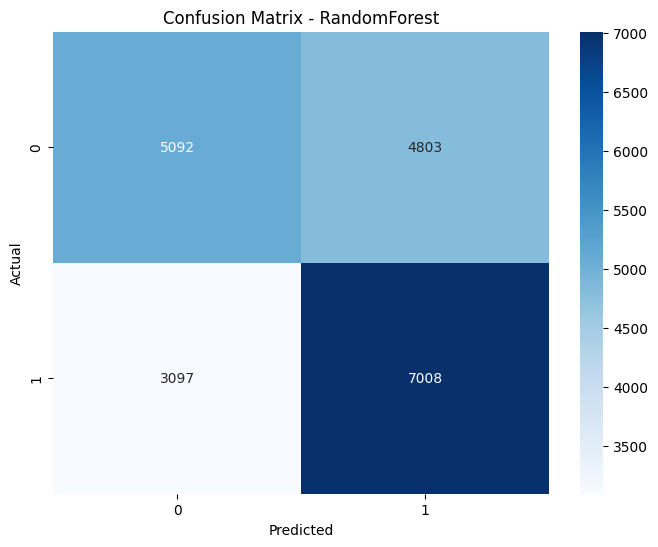


Top 10 Important Features for RandomForest:
                                               feature  importance
88   ratio_RealTimeProtectionState_NumAntivirusProd...    0.067096
92   ratio_AntivirusConfigID_NumAntivirusProductsIn...    0.058105
7                        NumAntivirusProductsInstalled    0.057349
96   ratio_NumAntivirusProductsInstalled_AntivirusC...    0.055278
76                                 EngineVersion_build    0.053109
81                              SignatureVersion_minor    0.052831
101  ratio_NumAntivirusProductsEnabled_NumAntivirus...    0.037643
93   ratio_AntivirusConfigID_NumAntivirusProductsEn...    0.036101
108                                 EngineVersion_freq    0.032482
95   ratio_NumAntivirusProductsInstalled_RealTimePr...    0.032411


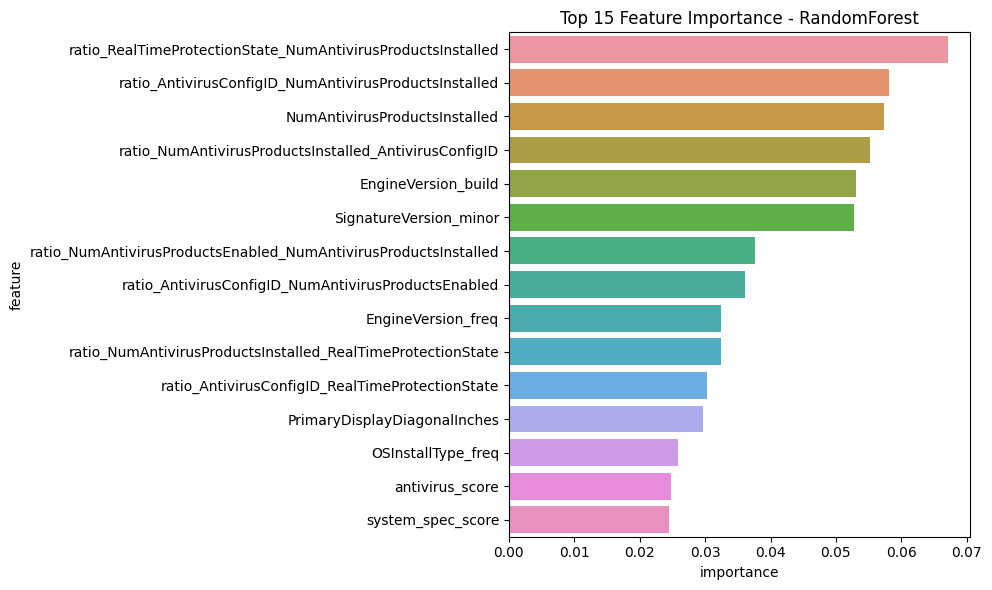


Training XGBoost...
XGBoost Results:
Training Accuracy: 0.6199
Validation Accuracy: 0.6189
CV Score: 0.6154 (+/- 0.0018)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      9895
           1       0.61      0.69      0.64     10105

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



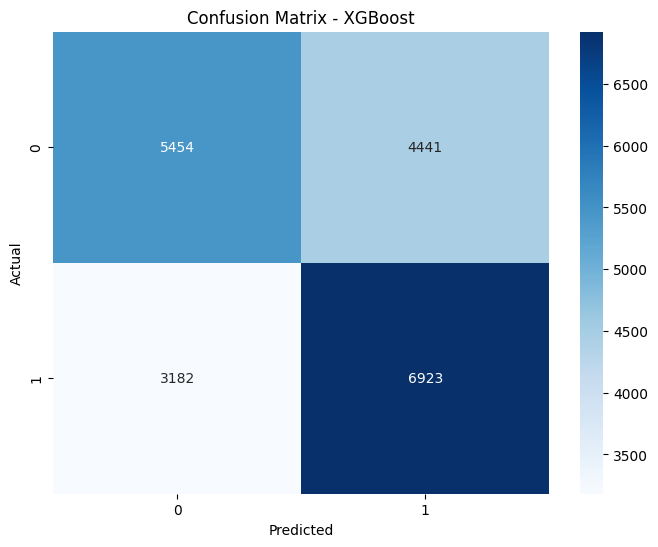


Top 10 Important Features for XGBoost:
                                               feature  importance
88   ratio_RealTimeProtectionState_NumAntivirusProd...    0.251712
92   ratio_AntivirusConfigID_NumAntivirusProductsIn...    0.055494
73                                   system_spec_score    0.045965
95   ratio_NumAntivirusProductsInstalled_RealTimePr...    0.038047
81                              SignatureVersion_minor    0.037992
1                                        EngineVersion    0.036102
40                        PrimaryDisplayDiagonalInches    0.033489
127                                 OSInstallType_freq    0.029409
79                                    AppVersion_build    0.028057
69                                              DateAS    0.027896


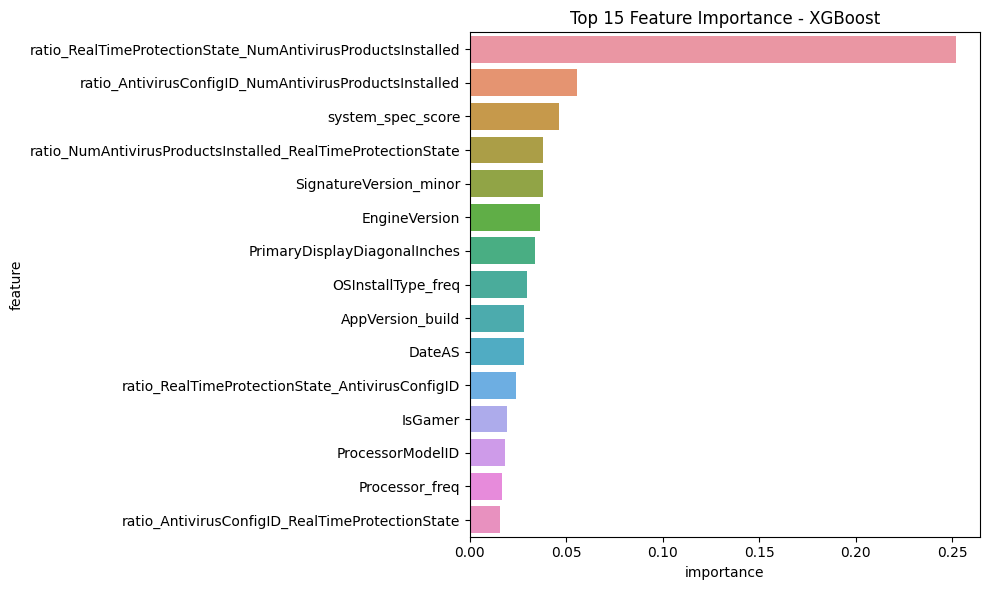


Training LightGBM...
[LightGBM] [Info] Number of positive: 40420, number of negative: 40420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16472
[LightGBM] [Info] Number of data points in the train set: 80840, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 20210, number of negative: 20210
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16765
[LightGBM] [Info] Number of data points in the train set: 40420, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg

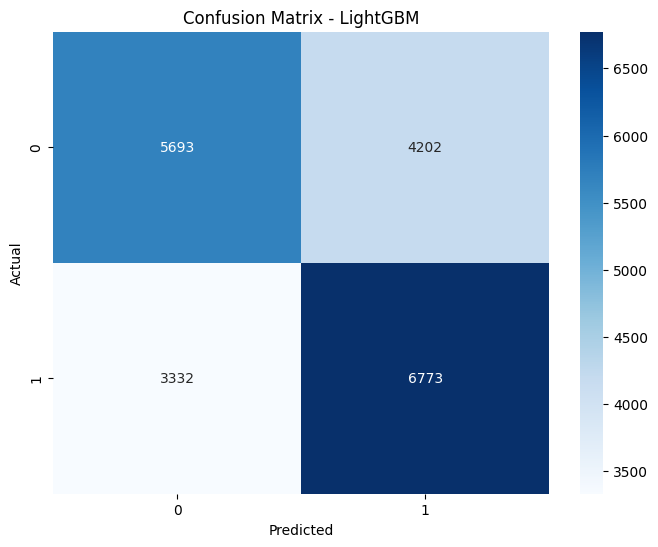


Top 10 Important Features for LightGBM:
                                               feature  importance
81                              SignatureVersion_minor          36
96   ratio_NumAntivirusProductsInstalled_AntivirusC...          34
82                              SignatureVersion_build          33
67                                             IsGamer          30
13                                 LocaleEnglishNameID          27
73                                   system_spec_score          27
127                                 OSInstallType_freq          26
79                                    AppVersion_build          26
2                                           AppVersion          24
133                                        DateOS_freq          22


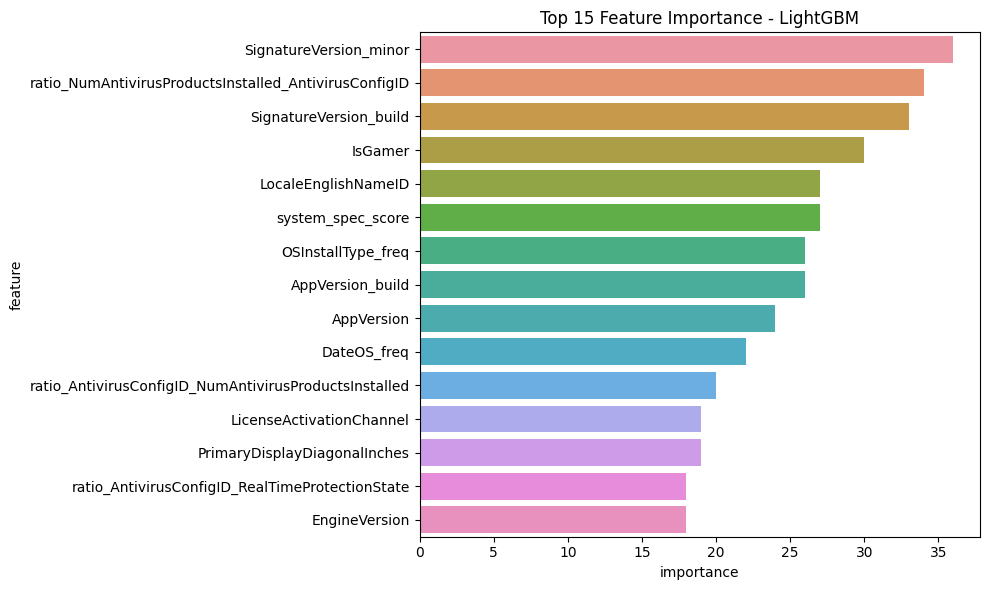


Model Comparison:
          Model  Training Accuracy  Validation Accuracy  CV Score
2      LightGBM           0.633102              0.62330  0.620324
1       XGBoost           0.619941              0.61885  0.615351
0  RandomForest           0.604379              0.60500  0.601163


<Figure size 1200x600 with 0 Axes>

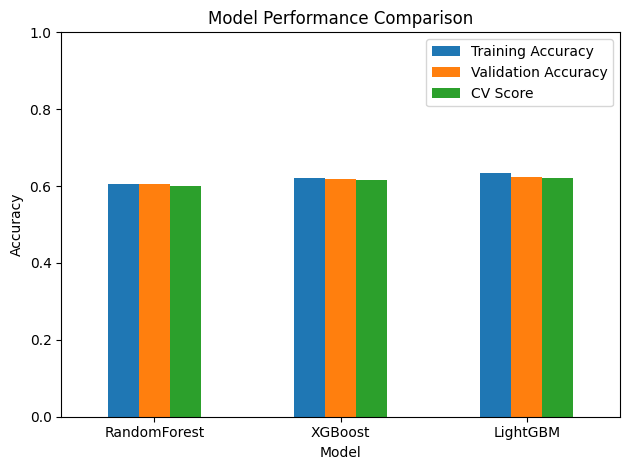

In [12]:
# Stage 7 : Model Training
print("\n--- Model Training and Evaluation ---")

# Initialize base models
#models = {
   # 'RandomForest': RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42),
    #'XGBoost': XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6, random_state=42),
    #'LightGBM': lgb.LGBMClassifier(n_estimators=1000, learning_rate=0.01, num_leaves=31, random_state=42)
#}
models = {
'RandomForest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
'XGBoost': XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42),
'LightGBM': lgb.LGBMClassifier(n_estimators=50, learning_rate=0.1, num_leaves=15, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_split_resampled, y_train_split_resampled)
    
    # Make predictions
    train_pred = model.predict(X_train_split_resampled)
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train_split_resampled, train_pred)
    val_accuracy = accuracy_score(y_val, val_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_split_resampled, y_train_split_resampled, cv=2)
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    # Print results
    print(f"{name} Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print("\nClassification Report:")
    print(classification_report(y_val, val_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val, val_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': X_train_split_resampled.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\nTop 10 Important Features for {name}:")
        print(importances.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importances.head(15))
        plt.title(f'Top 15 Feature Importance - {name}')
        plt.tight_layout()
        plt.show()

# Compare models
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Training Accuracy': [results[m]['train_accuracy'] for m in results],
    'Validation Accuracy': [results[m]['val_accuracy'] for m in results],
    'CV Score': [results[m]['cv_mean'] for m in results]
})

print("\nModel Comparison:")
print(model_comparison.sort_values('Validation Accuracy', ascending=False))

# Visualize model comparison
plt.figure(figsize=(12, 6))
model_comparison.set_index('Model').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [13]:
best_model_name = max(results.items(), key=lambda x: x[1]['val_accuracy'])[0]
print(f"\nBest performing model: {best_model_name}")



Best performing model: LightGBM


# **8. Hyperparameter Tuning**

In [14]:
# Stage 8 : Hyperparameter Tuning
print(f"\n--- Hyperparameter Tuning for {best_model_name} ---")

# Define parameter grids for each model type
#param_grids = {
        #'RandomForest': {
         #   'n_estimators': [100, 200, 300],
          #  'max_depth': [10, 20, 30],
           # 'min_samples_split': [2, 5, 10],
            #'min_samples_leaf': [1, 2, 4],
            #'max_features': ['sqrt', 'log2']
        #},
        #'XGBoost': {
         #   'n_estimators': [100, 200, 300],
          #  'max_depth': [3, 5, 7],
           # 'learning_rate': [0.01, 0.1, 0.3],
            #'subsample': [0.8, 0.9, 1.0],
            #'colsample_bytree': [0.8, 0.9, 1.0],
            #'min_child_weight': [1, 3, 5]
        #},
        #'LightGBM': {
         #   'n_estimators': [100, 200, 300],
          #  'max_depth': [5, 10, 15],
           # 'learning_rate': [0.01, 0.1, 0.3],
            #'num_leaves': [20, 31, 50],
            #'feature_fraction': [0.8, 0.9, 1.0],
            #'bagging_fraction': [0.8, 0.9, 1.0]
        #}
    #}
param_grids = {
'RandomForest': {
    'n_estimators': [50],
    'max_depth': [5]
},
'XGBoost': {
    'n_estimators': [50],
    'max_depth': [3],
    'learning_rate': [0.1]
},
'LightGBM': {
    'n_estimators': [50],
    'learning_rate': [0.1],
    'num_leaves': [15]
}
}

# Get the best model and its parameter grid
model = results[best_model_name]['model']
param_grid = param_grids[best_model_name]

print(f"Starting GridSearchCV for {best_model_name}")
print("Parameter grid:", param_grid)

# Perform grid search with fewer splits for speed
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # Reduced for faster execution
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_split_resampled, y_train_split_resampled)

# Print results
print("\nGrid Search Results:")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_estimator = grid_search.best_estimator_



--- Hyperparameter Tuning for LightGBM ---
Starting GridSearchCV for LightGBM
Parameter grid: {'n_estimators': [50], 'learning_rate': [0.1], 'num_leaves': [15]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 40420, number of negative: 40420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16472
[LightGBM] [Info] Number of data points in the train set: 80840, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Grid Search Results:
Best parameters: {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 15}
Best cross-validation score: 0.6201879965394922


In [15]:
results[best_model_name]['model'] = best_estimator

In [16]:
tuned_preds = best_estimator.predict(X_val)
print("\nTuned Model Performance:")
print("Accuracy:", accuracy_score(y_val, tuned_preds))
print("\nClassification Report:")
print(classification_report(y_val, tuned_preds))


Tuned Model Performance:
Accuracy: 0.6233

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60      9895
           1       0.62      0.67      0.64     10105

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



# **9. Ensemble Modeling**

In [17]:
# Stage 9 : Ensemble Modeling

print("\n--- Creating Stacking Ensemble ---")

# Define base models
#base_models = [
    #    ('lgb', lgb.LGBMClassifier(**best_params)),
   #     ('cat', CatBoostClassifier(iterations=5000, learning_rate=0.005, depth=10, verbose=False)),
  #      ('xgb', XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=6, random_state=42)),
 #       ('rf', RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42))
#]
base_models = [
    ('rf', results['RandomForest']['model']),
    ('xgb', results['XGBoost']['model']),
    ('lgb', results['LightGBM']['model'])
]

# Define meta-model
meta_model = LogisticRegression()

# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train stacking model
stacking_model.fit(X_train_processed, y_train)



--- Creating Stacking Ensemble ---
[LightGBM] [Info] Number of positive: 50525, number of negative: 49475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8749
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8636
[LightGBM] [Info] Number of data points in the train set: 80000, number of 

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              g...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=50, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lgb',
                                LGBMClassifier(n_estimators=50, num_leaves=15,
                                               random_state=42))],
                   final_estimator=LogisticRegression())

In [19]:
# Evaluate stacking model
stacking_preds = stacking_model.predict(X_val)
print("\nStacking Ensemble Performance:")
print("Accuracy:", accuracy_score(y_val, stacking_preds))
print("\nClassification Report:")
print(classification_report(y_val, stacking_preds))

# Compare final models
final_comparison = pd.DataFrame({
    'Model': ['Tuned ' + best_model_name, 'Stacking Ensemble'],
    'Validation Accuracy': [
        accuracy_score(y_val, tuned_preds),
        accuracy_score(y_val, stacking_preds)
    ]
})

print("\nFinal Model Comparison:")
print(final_comparison.sort_values('Validation Accuracy', ascending=False))

# Choose the best final model
if accuracy_score(y_val, tuned_preds) >= accuracy_score(y_val, stacking_preds):
    final_model = tuned_model
    print(f"\nSelected final model: Tuned {best_model_name}")
else:
    final_model = stacking_model
    print("\nSelected final model: Stacking Ensemble")



Stacking Ensemble Performance:
Accuracy: 0.63295

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      9895
           1       0.63      0.67      0.65     10105

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000


Final Model Comparison:
               Model  Validation Accuracy
1  Stacking Ensemble              0.63295
0     Tuned LightGBM              0.62330

Selected final model: Stacking Ensemble


# **10. Submission Generation**

In [20]:
# Stage 10 : Submission.csv

print("\n--- Making Predictions and Creating Submission ---")

# Make predictions
predictions = final_model.predict(X_test_processed)

# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'target': predictions
})

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'!")



--- Making Predictions and Creating Submission ---
Submission saved to 'submission.csv'!
